#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 15
**CH15A Predicting used car value with regression trees**

using the used-cars dataset

version 0.9.0 2025-08-14

In [66]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import pyfixest as pf
from skmisc.loess import loess
from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [67]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch15-used-cars-cart/"
output = dirname + "da_case_studies/ch15-used-cars-cart/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [68]:
# Import the prewritten helper functions
import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)

In [ ]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")
# data = pd.read_csv("https://osf.io/7gvz9/download")

In [70]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [71]:
data["condition"].value_counts()

condition
excellent    139
good         114
like new      55
fair          15
new            4
Name: count, dtype: int64

In [72]:
data["condition"] = data["condition"].fillna("good")

In [73]:
data["condition"].value_counts()

condition
good         336
excellent    139
like new      55
fair          15
new            4
Name: count, dtype: int64

In [74]:
# Drop hybrid models and the 'Hybrid' column
data = data.loc[lambda df: df["Hybrid"] == 0].drop(columns=["Hybrid"])

# Keep only gas-fueled vehicles
data = data.loc[lambda df: df["fuel"] == "gas"]

# Drop vehicles in fair and new condition
data = data.loc[lambda df: ~df["condition"].isin(["new", "fair"])]

# Drop unrealistic values for price and odometer reading
data = data.loc[lambda df: df["price"].between(500, 25000) & (df["odometer"] <= 100)]

# Drop if price is smaller than 1000 and condition is 'like new' or age is less than 8
data = data.loc[
    lambda df: ~(
        (df["price"] < 1000) & ((df["condition"] == "like new") | (df["age"] < 8))
    )
]

# Drop manual transmission
data = data.loc[lambda df: df["transmission"] != "manual"]

# Drop trucks and pickups
data = data.loc[lambda df: ~df["type"].isin(["truck", "pickup"])]

# Drop 'pricestr' column
data = data.drop(columns=["pricestr"])

In [75]:
# to be on the safe side
data = data[data["price"].notna()]
data = data.reset_index(drop=True)

In [76]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# chicago
data["chicago"] = np.where(data["area"] == "chicago", 1, 0)
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2
data.to_csv("usedcars_work.csv", index=False)

In [77]:
data.price.describe()

count      477.000000
mean      5843.878407
std       4334.571604
min        500.000000
25%       2500.000000
50%       4400.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [78]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=123)

### Regression tree
---

In [79]:
data_train["price"].describe()

count      333.000000
mean      5883.390390
std       4392.305442
min        500.000000
25%       2500.000000
50%       4499.000000
75%       7899.000000
max      18500.000000
Name: price, dtype: float64

In [80]:
cart1 = DecisionTreeRegressor(random_state=123, max_depth=1)

# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart1.fit(X, Y)

DecisionTreeRegressor(max_depth=1, random_state=123)

In [81]:
pred_cart1 = cart1.predict(data_test[["age"]])

rmse_cart1 = root_mean_squared_error(data_test["price"], pred_cart1)

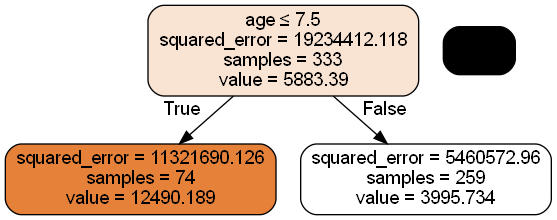

In [82]:
da.plot_decision_tree(
    cart1, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)

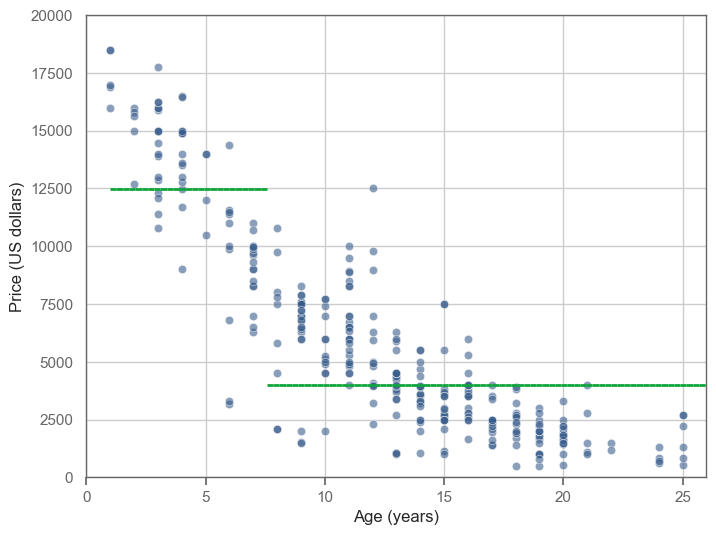

In [83]:
da.plot_model_predictions(cart1, data_train, "age", "price")

In [84]:
###########
# Splits at two levels
# (make sure it stops by setting "max_depth" to 2)

In [85]:
cart2 = DecisionTreeRegressor(random_state=123, max_depth=2)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart2.fit(X, Y)

DecisionTreeRegressor(max_depth=2, random_state=123)

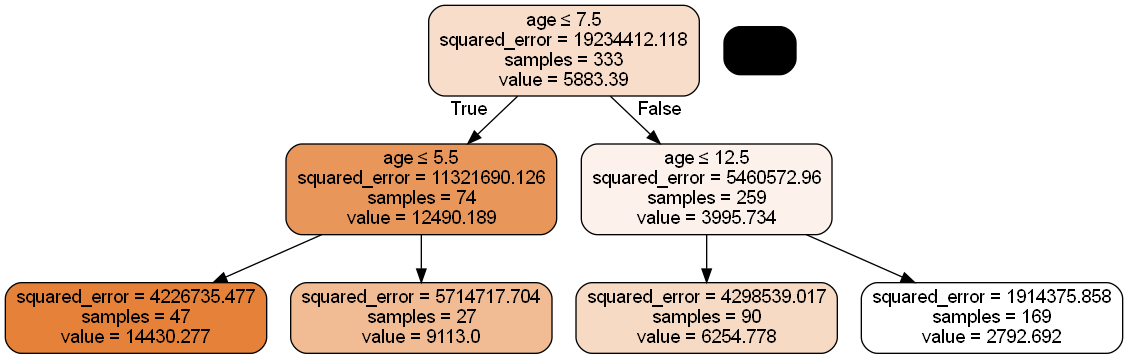

In [86]:
da.plot_decision_tree(
    cart2, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)

In [87]:
(
    data_train[["age"]]
    .assign(Average_price=cart2.predict(X))
    .groupby("Average_price")
    .agg(age_min=("age", "min"), age_max=("age", "max"), Count=("age", "count"))
    .reset_index()
    .sort_values("age_min")
    .assign(
        Category=lambda x: x.apply(
            lambda row: (f"Age {int(row['age_min'])}-{int(row['age_max'])}"),
            axis=1,
        )
    )
    .filter(["Category", "Count", "Average_price"])
    .round(2)
)

,Category,Count,Average_price
3,Age 1-5,47,14430.28
2,Age 6-7,27,9113.00
1,Age 8-12,90,6254.78
0,Age 13-27,169,2792.69


In [88]:
data_train.loc[(data_train.age > 1) & (data_train.age < 12), :].shape

(144, 29)

In [89]:
pred_cart2 = cart2.predict(data_test[["age"]])

rmse_cart2 = root_mean_squared_error(data_test["price"], pred_cart2)

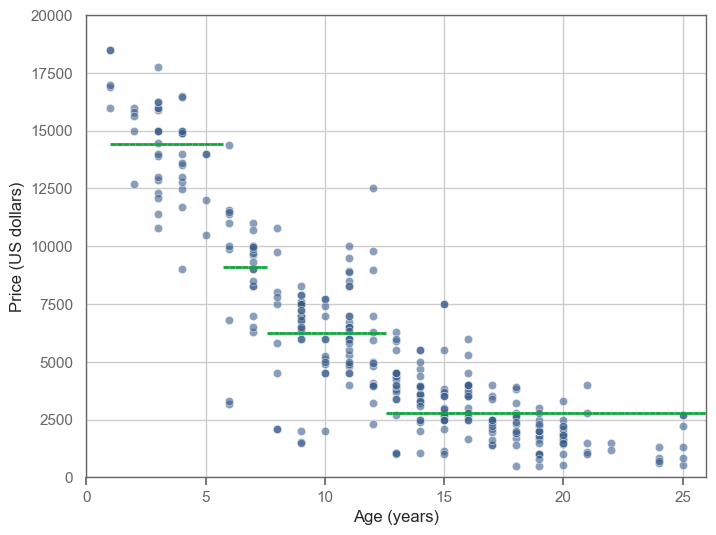

In [90]:
da.plot_model_predictions(cart2, data_train, "age", "price")

**Note**: min_impurity_decrease in sklearn is considered to be the same as cp in caret, the actual values are different but the purpose is the same

In [91]:
cart3 = DecisionTreeRegressor(random_state=123, min_impurity_decrease=50000)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart3.fit(X, Y)

DecisionTreeRegressor(min_impurity_decrease=50000, random_state=123)

In [92]:
pred_cart3 = cart3.predict(data_test[["age"]])

rmse_cart3 = root_mean_squared_error(data_test["price"], pred_cart3)
rmse_cart3

2266.1958643489297

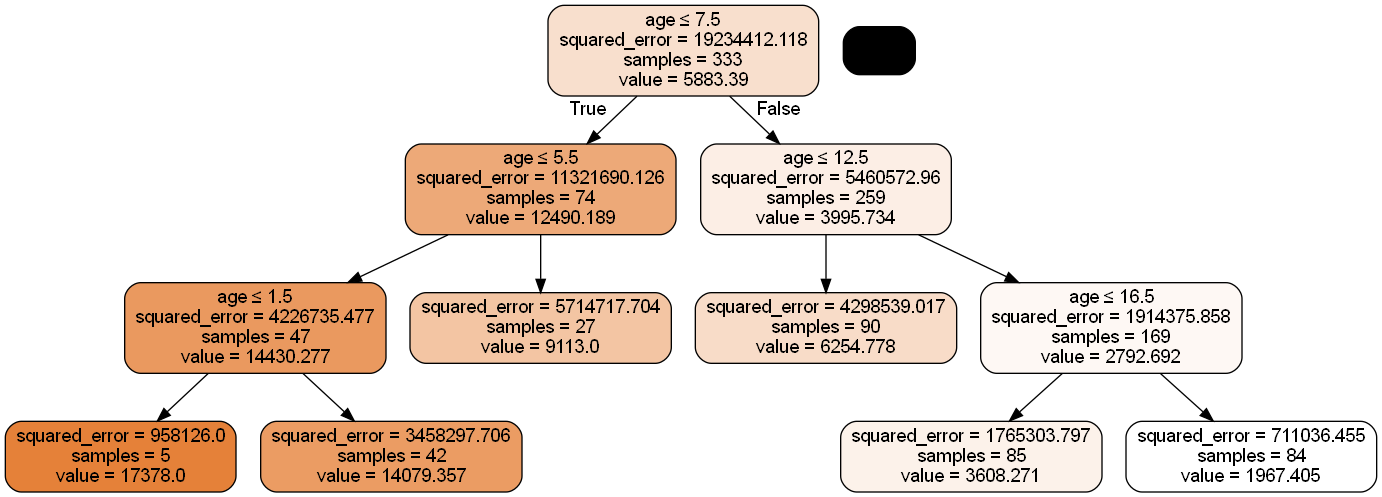

In [93]:
da.plot_decision_tree(
    cart3, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)

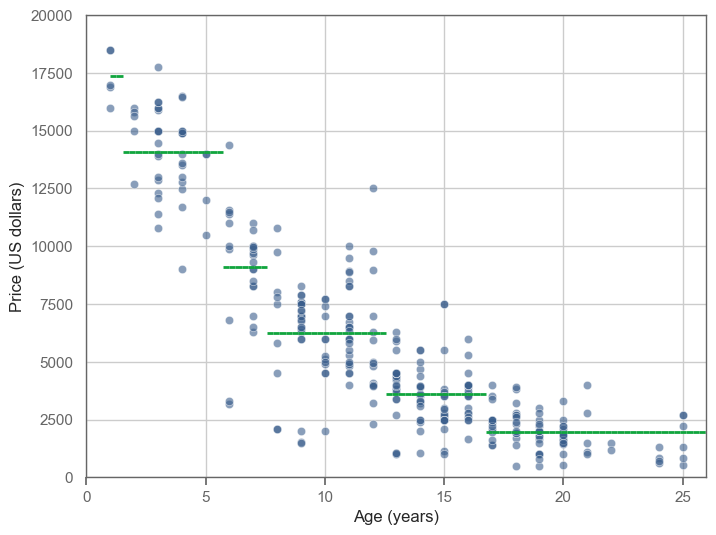

In [94]:
da.plot_model_predictions(cart3, data_train, "age", "price")

#### Age only linear regression
---

In [95]:
linreg1 = pf.feols("price~age", data=data_train)
linreg1.summary()

###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept     |  13998.028 |      291.555 |    48.012 |      0.000 | 13424.493 | 14571.562 |
| age           |   -655.390 |       21.353 |   -30.693 |      0.000 |  -697.395 |  -613.386 |
---
RMSE: 2236.277 R2: 0.74 


In [96]:
pred_linreg1 = linreg1.predict(data_test)
rmse_ols1 = root_mean_squared_error(data_test["price"], pred_linreg1)
rmse_ols1

2433.387411077362

In [97]:
## Scatterplot with predicted values
pred_linreg1t = linreg1.predict(data_train)

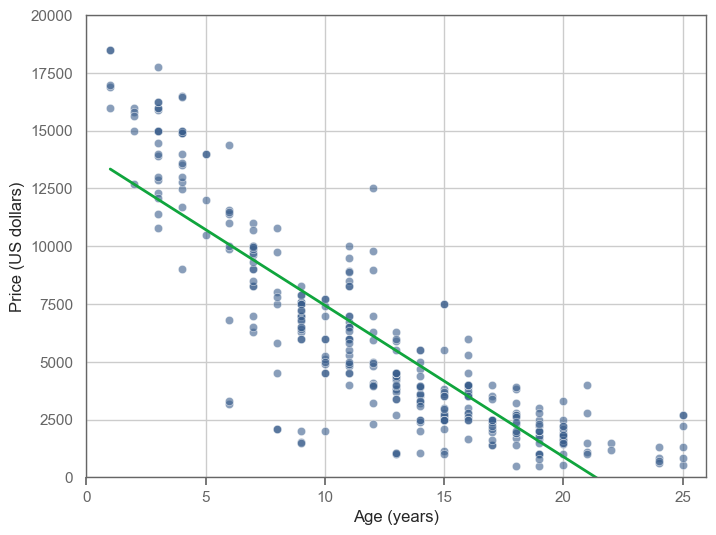

In [98]:
da.plot_model_predictions(linreg1, data_train, "age", "price")

In [99]:
#### Age only only lowess

loess_model = loess(data["age"], data["price"], span=0.8)
loess_model.fit()

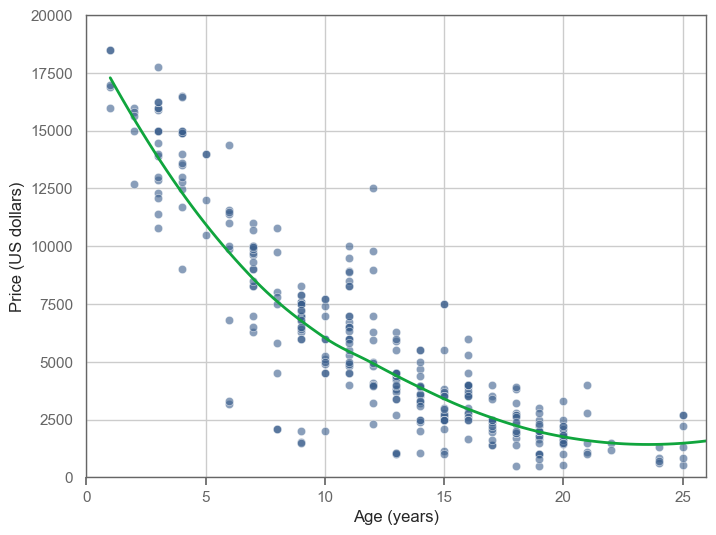

In [100]:
da.plot_model_predictions(loess_model, data_train, "age", "price")

### MULTIPLE PREDICTOR VARIABLES

In [101]:
# Linear regression with multiple variables
model2_X_vars = [
    "age",
    "odometer",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]
model2 = "price ~ " + " + ".join(model2_X_vars)
linreg2 = pf.feols(model2, data_train)
linreg2.summary()

###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept      |  14537.565 |      421.738 |    34.471 |      0.000 | 13707.856 | 15367.274 |
| age            |   -406.927 |       26.376 |   -15.428 |      0.000 |  -458.818 |  -355.035 |
| odometer       |   -297.295 |       28.533 |   -10.419 |      0.000 |  -353.430 |  -241.161 |
| LE             |   -278.003 |      242.505 |    -1.146 |      0.252 |  -755.097 |   199.090 |
| XLE            |    832.285 |      411.751 |     2.021 |      0.044 |    22.223 |  1642.346 |
| SE             |    570.647 |      339.578 |     1.680 |      0.094 |   -97.425 |  1238.719 |
| cond_excellent |   -698.571 |      387.590 |    -1.802 |      0.072 | -1461.100 |    63.958 |
| cond_good      |   -269.385 |      370.57

In [102]:
pred_linreg2 = linreg2.predict(data_test)
rmse_linreg2 = root_mean_squared_error(data_test["price"], pred_linreg2)
rmse_linreg2

2111.871881834073

In [103]:
# add squared for age, odometer
model3_X_vars = [
    "age",
    "agesq",
    "odometer",
    "odometersq",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]
model3 = "price ~ " + " + ".join(model3_X_vars)
linreg3 = pf.feols(model3, data_train)
linreg3.summary()

###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept      |  18458.578 |      421.341 |    43.809 |      0.000 | 17629.630 | 19287.526 |
| age            |   -947.126 |       70.910 |   -13.357 |      0.000 | -1086.634 |  -807.618 |
| agesq          |     20.318 |        2.439 |     8.330 |      0.000 |    15.519 |    25.116 |
| odometer       |   -616.968 |       69.614 |    -8.863 |      0.000 |  -753.927 |  -480.008 |
| odometersq     |     14.684 |        2.425 |     6.055 |      0.000 |     9.913 |    19.454 |
| LE             |      6.213 |      188.825 |     0.033 |      0.974 |  -365.282 |   377.708 |
| XLE            |    407.409 |      320.014 |     1.273 |      0.204 |  -222.187 |  1037.006 |
| SE             |    380.403 |      265.32

In [104]:
pred_linreg3 = linreg3.predict(data_test)
rmse_linreg3 = root_mean_squared_error(data_test["price"], pred_linreg3)
rmse_linreg3

1841.8579313394162

In [105]:
from sklearn.preprocessing import OneHotEncoder

In [106]:
OneHotEncoder().fit_transform(data_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9657 stored elements and shape (333, 1359)>

In [107]:
# Tree

# Splits at four levels, for illustrative purposes
# (make sure it stops by setting "maxdepth" to 3)

X = data_train[model2_X_vars]
y = data_train["price"]
X_test = data_test[model2_X_vars]
y_test = data_test["price"]

cart4 = DecisionTreeRegressor(random_state=123, max_depth=3)
cart4.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=123)

In [108]:
pred_cart4 = cart4.predict(X_test)
rmse_cart4 = root_mean_squared_error(y_test, pred_cart4)
rmse_cart4

2051.1691218693722

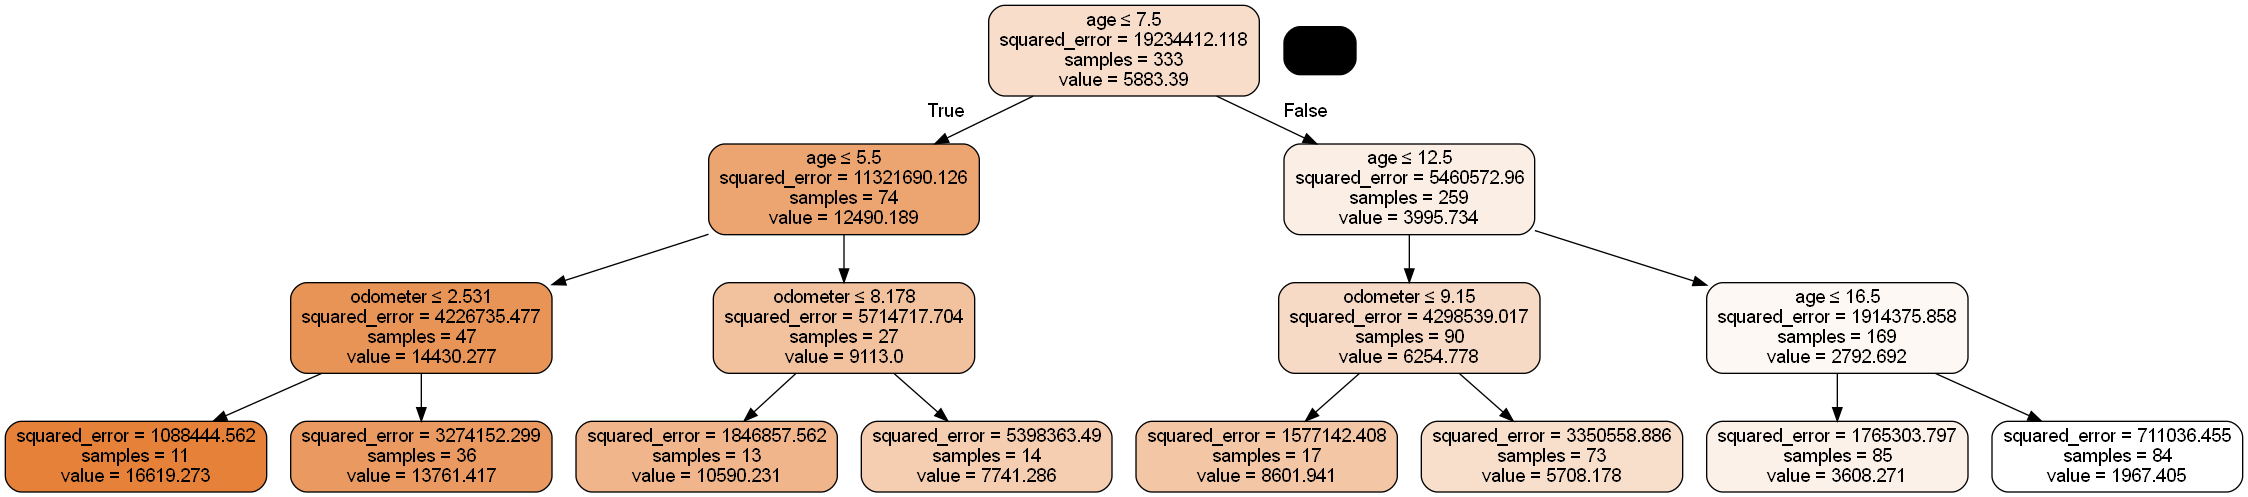

In [109]:
da.plot_decision_tree(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

In [110]:
# alternative to show the use of min_impurity_decrease
# slightly the same outcome

In [111]:
cart4 = DecisionTreeRegressor(
    random_state=123,
    min_impurity_decrease=145000,
    min_samples_split=20,
)
cart4.fit(X, Y)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = root_mean_squared_error(y_test, pred_cart4)
rmse_cart4

2051.1691218693722

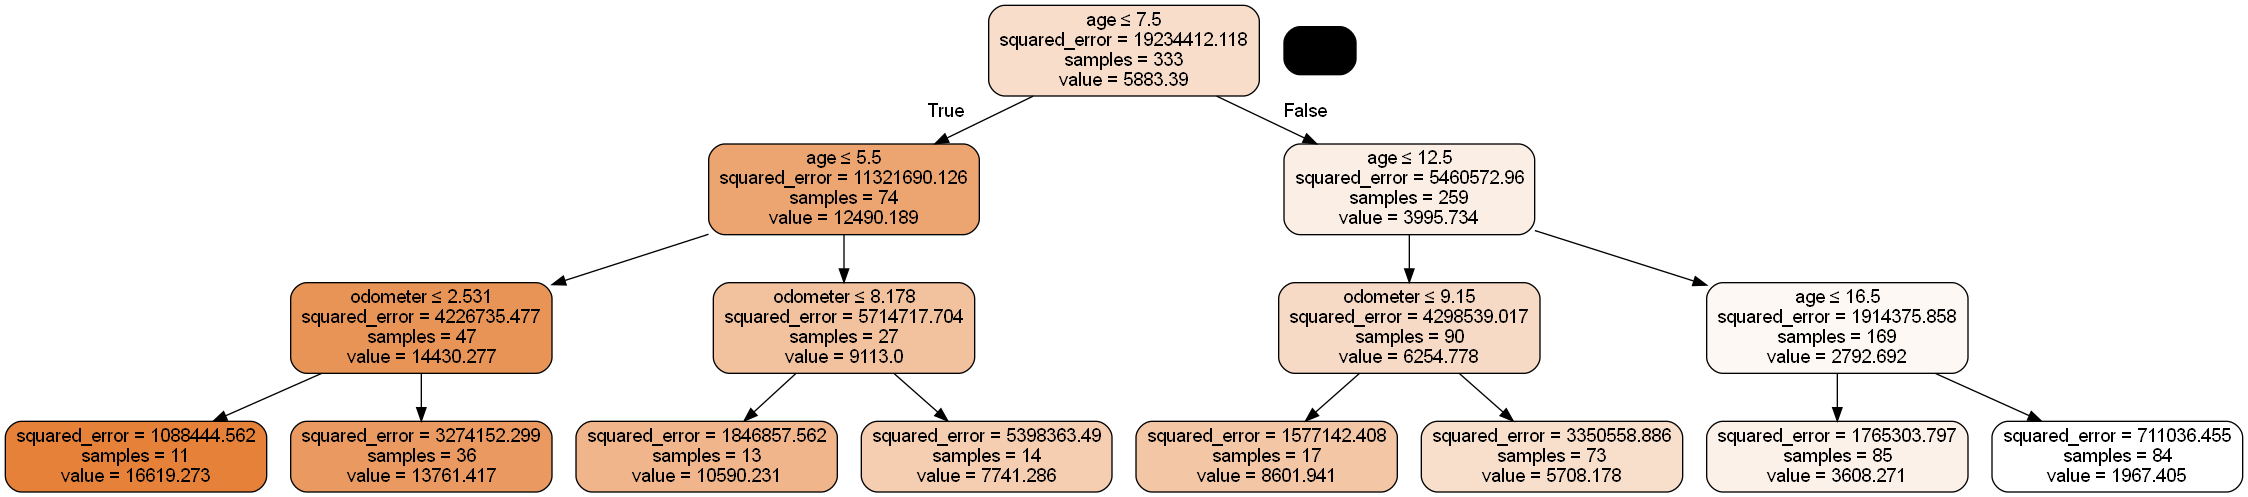

In [112]:
da.plot_decision_tree(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

In [113]:
# CART M5
cart5 = DecisionTreeRegressor(random_state=123, min_impurity_decrease=20000)
cart5.fit(X, Y)

DecisionTreeRegressor(min_impurity_decrease=20000, random_state=123)

In [114]:
pred_cart5 = cart5.predict(X_test)
rmse_cart5 = root_mean_squared_error(y_test, pred_cart5)
rmse_cart5

2230.3702214698933

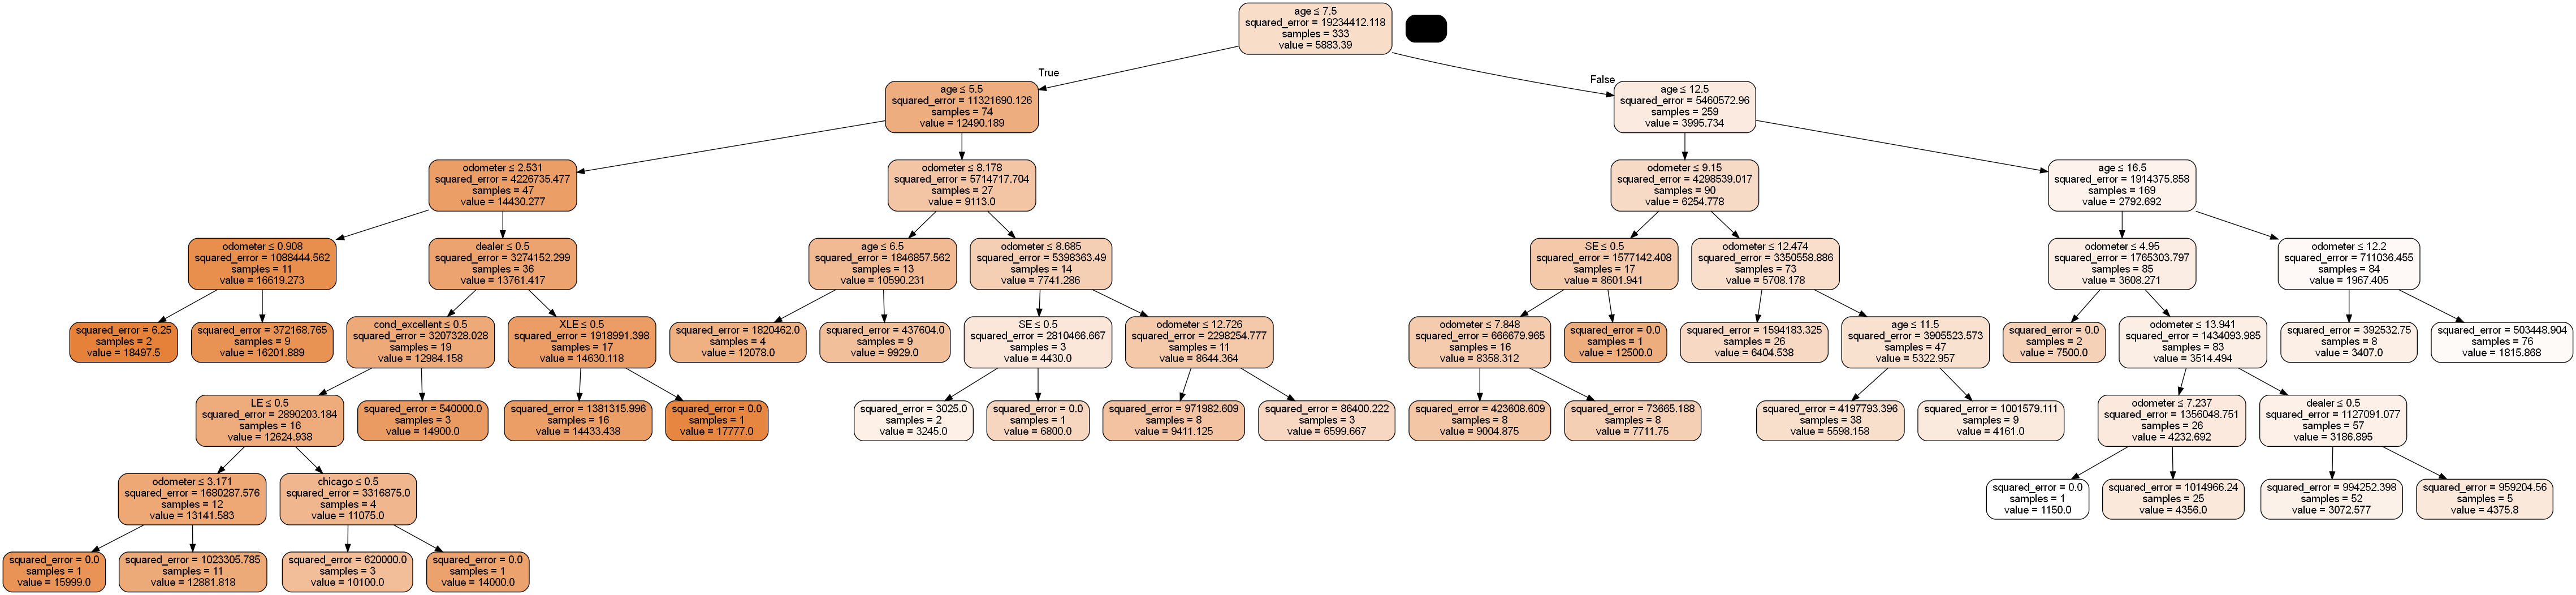

In [115]:
da.plot_decision_tree(
    cart5,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

In [116]:
# build very large tree and prune it
# in Python this can be done in sklearn's DecisionTreeRegressor with ccp_alpha parameter
cart6 = DecisionTreeRegressor(random_state=20108, min_samples_split=4, ccp_alpha=30000)
cart6.fit(X, Y)

DecisionTreeRegressor(ccp_alpha=30000, min_samples_split=4, random_state=20108)

In [117]:
pred_cart6 = cart6.predict(X_test)
rmse_cart6 = root_mean_squared_error(y_test, pred_cart6)
rmse_cart6

2036.2688014814048

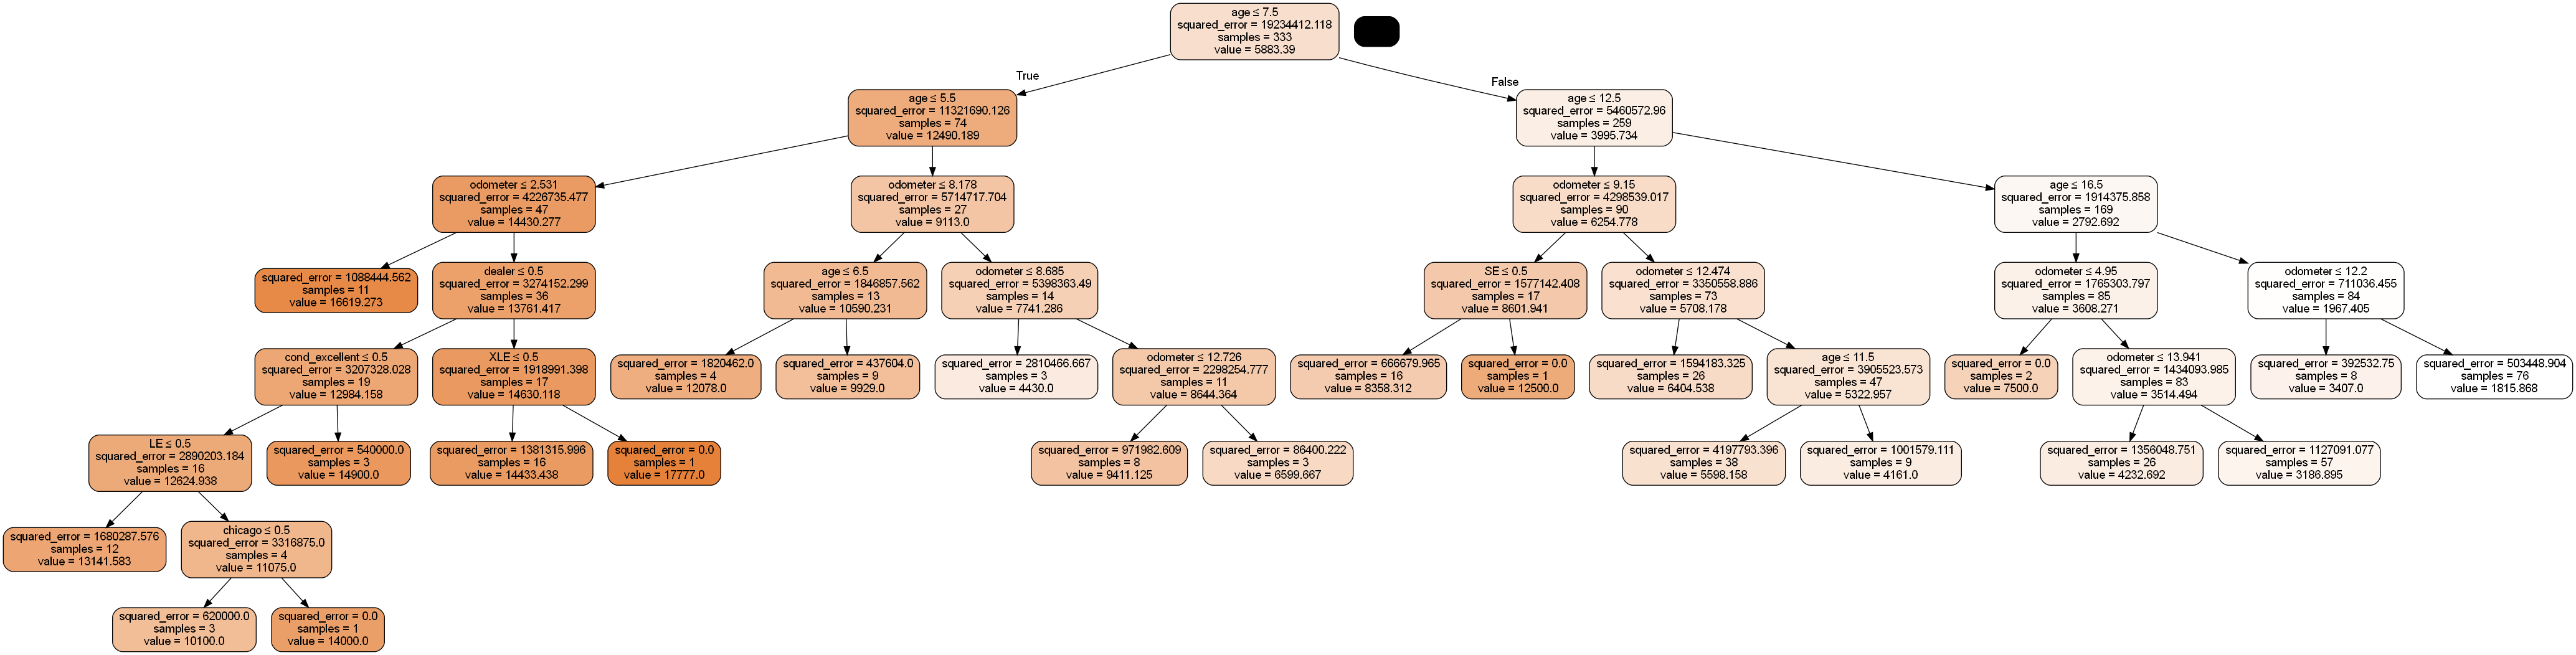

In [118]:
da.plot_decision_tree(
    cart6,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

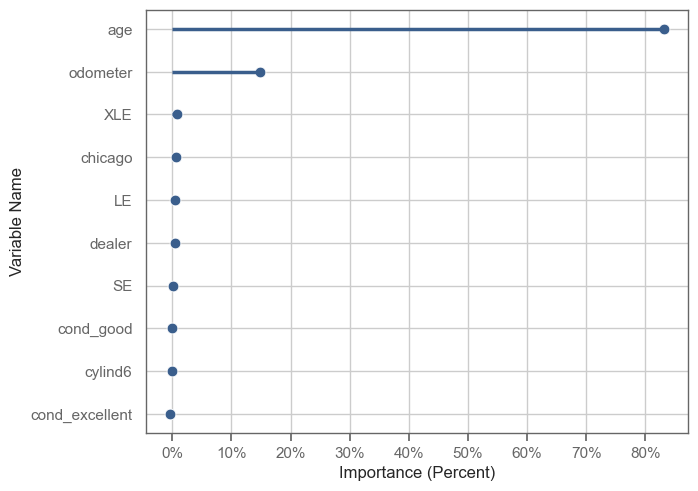

In [119]:
# Variable (permutation) importance for model 6 (not in book)

perm_imp = permutation_importance(
    cart6,
    X_test,
    y_test,
    n_repeats=100,
    scoring="neg_root_mean_squared_error",
    random_state=20108,
)

cart6_var_imp_df = pd.DataFrame(
    [perm_imp["importances_mean"], X_test.columns],
    index=["imp", "varname"],
).T.assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())

da.plot_variable_importance(cart6_var_imp_df)

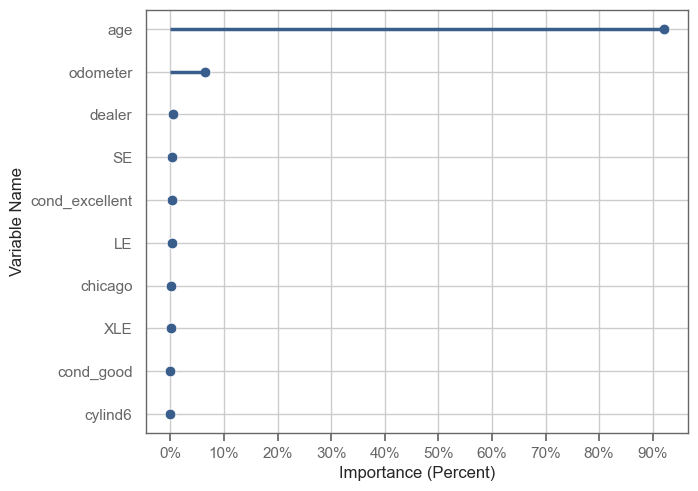

In [120]:
# Variable importance for model 6

cart6_var_imp_df = pd.DataFrame(
    [cart6.feature_importances_, X_test.columns],
    index=["imp", "varname"],
).T.assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())

da.plot_variable_importance(cart6_var_imp_df)

In [121]:
pd.DataFrame(
    {
        "Model": ["CART M" + str(i) for i in range(1, 7)]
        + ["OLS M" + str(i) for i in range(1, 4)],
        "Number of variables": [1, 1, 7, 7, 7, 7, 1, 7, 7],
        "Model details": [
            "2 levels",
            "3 levels",
            "min_impurity_decrease=50000",
            "min_impurity_decrease=140000 & min_samples_split=20",
            "min_impurity_decrease=20000",
            "ccp_alpha=30000",
            "linear",
            "linear",
            "w/ polynomial terms",
        ],
        "RMSE": [
            rmse_cart1,
            rmse_cart2,
            rmse_cart3,
            rmse_cart4,
            rmse_cart5,
            rmse_cart6,
            rmse_ols1,
            rmse_linreg2,
            rmse_linreg3,
        ],
    }
).set_index("Model").round(2)

,Number of variables,Model details,RMSE
Model,,,
CART M1,1,2 levels,2785.05
CART M2,1,3 levels,2381.82
CART M3,7,min_impurity_decrease=50000,2266.20
CART M4,7,min_impurity_decrease=140000 & min_samples_spl...,2051.17
CART M5,7,min_impurity_decrease=20000,2230.37
CART M6,7,ccp_alpha=30000,2036.27
OLS M1,1,linear,2433.39
OLS M2,7,linear,2111.87
OLS M3,7,w/ polynomial terms,1841.86
